# Buffer circulaire (ring buffer)

Un buffer circulaire est une structure de données utilisant une zone mémoire de taille fixe et dont le début et la fin sont connectés. On peut conceptuellement la représenter par une aube avec un pointeur indiquant la dernière valeur entrée.
Les buffers circulaires sont souvent utilisés pour gérer des flux de données ou pour implémenter un comportement de type FIFO. 

Ici, on se propose d'implémenter une solution moins optimale.

Définir une classe __RingBuffer__ permettant de stocker __NbSamples__ dans un tableau numpy __samples__.
La valeur par défaut de __NbSamples__  est 10.

Définir une fonction membre __update__ permettant d'insérer une valeur à gauche du tableau. Celles déjà contenues
sont déplacées d'une case à droite.


In [1]:
import numpy as npy

class RingBuffer:
    def __init__(self, NbSamples=10):
        self.NbSamples = NbSamples
        self.samples=npy.zeros((NbSamples,), dtype=npy.float64)
               
    def update(self, newsample):
        self.samples[1:]=self.samples[0:self.NbSamples-1] # peu couteux pour un petit tableau
        self.samples[0]= newsample
        
    def __repr__(self): 
        return npy.array_repr(self.samples, precision=6, suppress_small=True)

## Tests 
Procéder à quelques tests. Afficher les attributs d'un objet avec la fonction magique __\_\_dict\_\___

In [2]:
ring=RingBuffer(10)

for n in range(12):
    ring.update(n)

print(ring.__dict__)
print(ring.samples)
print(ring.__dict__['NbSamples'])

{'NbSamples': 10, 'samples': array([11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.])}
[11. 10.  9.  8.  7.  6.  5.  4.  3.  2.]
10


## Sécurisation des données
Restreindre l'accès aux données de votre classe

La fonction publique __NbSamples__ retourne le nombre d'échantillons. Montrer que l'utilisation d'un __property__
permet de simplifier son appel.

La surcharge de l'opérateur [ ] se fait grâce à la fonction magique __\_\_getitem\_\___(self, ix)
qui retournera la valeur de l'échantillon d'indice relatif ix par rapport au pointeur courant pointer.

La fonction publique __samples__ retourne les valeurs du tableau \_\_samples. Montrer que l'utilisation d'un __property__
permet de simplifier son appel.


In [4]:
import random
import math
import numpy as npy


class RingBuffer:
    def __init__(self, NbSamples=10):
        self.__NbSamples = NbSamples
        self.__samples=npy.zeros((NbSamples,), dtype=float)
    
    def update(self, newsample):
        self.__samples[1:]=self.__samples[0:self.__NbSamples-1]
        self.samples[0]= newsample      

    @property  # getter 
    def NbSamples(self):
        return self.__NbSamples
    
    def __getitem__(self, ix):
        return self.__samples[ix % self.__NbSamples]
    
    def __repr__(self):
        return npy.array_repr(self.__samples, precision=6, suppress_small=True)
    
    @property
    def samples(self):
        return self.__samples

In [5]:
ring=RingBuffer(10)
ring.update(1)
ring.update(2)
print(ring[-2], ring[-1], ring[0], ring[1])
print(ring)
print(ring.samples)
print(ring.NbSamples)

0.0 0.0 2.0 1.0
array([2., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
[2. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
10


# FIR  (Finite Impulse Filter)

Notre but est de définir une classe FIR_filter permettant de calculer la moyenne pondérée d'un signal temporel sur une fenêtre glissante. Les poids dont la somme vaut 1 seront donnés en argument lorsque de la construction d'une instance de la classe FIR_filter, sous la forme d'un numpy array appelé weights. Il sera généré à l'extérieur de la classe

weights=npy.array([1/(x+1) for x in range(16)])    
weights /= weights.sum()

weights[0] pondera le dernier échantillon entré, weights[1] le précédent, ainsi de suite.

* Bien avant de définir le constructeur, __en utilisant un property__, on vous demande de définir 
le getter __weight(self)__ set le setter __weights(self, x)__. 
Le getter retournera le tableau des poids retournés et le setter initialisera les poids à partir d'un tableau
passé en argument (Ne pas oublier de le retourner). Il mettra à jour la donnée privée \_\_NbSamples\_\_ avec la taille
de ce tableau.

* Définir ensuite le constructeur \_\_init()\_\_, on utilisera une instance de la classe RingBuffer pour stocker le signal échantillonné.

* Définir une fonction publique __insert()__ qui permettra d'insérer un nouvel échantillon dans le buffer circulaire et qui calculera la moyenne pondérée des échantillons.



In [5]:
class FIR_filter:
    def __init__(self, data):
        self.weights  = data # appel le setter et calcule __NbSamples
        self.__buffer   = RingBuffer(self.__NbSamples)

    @property  # getter 
    def NbSamples(self):
        return self.__NbSamples
    
    @property
    def weights(self):
        return self.__weights
    
    @weights.setter
    def weights(self, x):
        print('setter')
        self.__weights = npy.array(x, dtype=npy.float64)
        self.__NbSamples = self.__weights.shape[0]
        
    def insert(self, x):   
        self.__buffer.update(x)
        return (self.weights * self.__buffer.samples).sum()

setter
weights :  [0.29579419 0.1478971  0.09859806 0.07394855 0.05915884 0.04929903
 0.04225631 0.03697427 0.03286602 0.02957942 0.02689038 0.02464952
 0.0227534  0.02112816 0.01971961 0.01848714]
------------


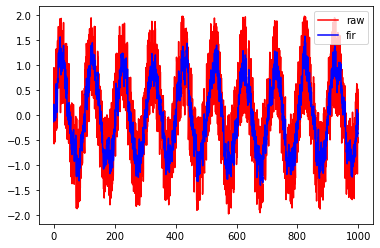

In [6]:
import matplotlib.pyplot as plt

weights=npy.array([1/(x+1) for x in range(16)])    
weights /= weights.sum()
    
fir = FIR_filter(weights)
print("weights : ", fir.weights)
print('------------')

r=random.seed(1452)
  
raw_data=[]
fir_data=[]
time =[]

NT=2000
T =100 # period
dt=0.5    # time step
for nt in range(NT):
    t = nt*dt
    r=random.uniform(-1., 1.)
    s=math.sin(2*math.pi/T*t)+r
    sf=fir.insert(s)
    time.append(t)
    raw_data.append(s)
    fir_data.append(sf)

plt.figure()
plt.plot(time, raw_data, 'r-')
plt.plot(time, fir_data, 'b-')
plt.draw()
plt.legend(('raw', 'fir'), loc='upper right')

# Appel de la fonction magique \_\_call()\_\_
On peut encore remplacer l'appel explicite de la fonction __insert__ par l'opérateur () appliqué à l'instance de la classe
FIR_filter. Pour cela, il faut implémenter dans la classe, la fonction magique \_\_call()\_\_.

In [7]:
class FIR_filter:
    def __init__(self, data):
        self.weights  = data # appel le setter et calcule __NbSamples
        self.__buffer   = RingBuffer(self.__NbSamples)

    @property  # getter 
    def NbSamples(self):
        return self.__NbSamples
    
    @property
    def weights(self):
        return self.__weights
    
    @weights.setter
    def weights(self, x):
        print('setter')
        self.__weights = npy.array(x, dtype=npy.float64)
        self.__NbSamples = self.__weights.shape[0]
        
    def __call__(self, x):   # implementation de la fonction call.
        self.__buffer.update(x)
        return (self.weights * self.__buffer.samples).sum()

setter
weights :  [0.29579419 0.1478971  0.09859806 0.07394855 0.05915884 0.04929903
 0.04225631 0.03697427 0.03286602 0.02957942 0.02689038 0.02464952
 0.0227534  0.02112816 0.01971961 0.01848714]
------------


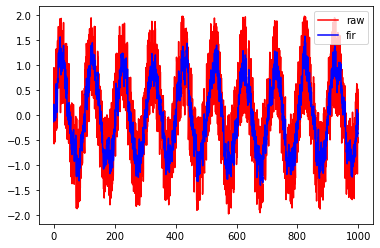

In [8]:
import matplotlib.pyplot as plt

weights=npy.array([1/(x+1) for x in range(16)])    
weights /= weights.sum()
    
fir = FIR_filter(weights)
print("weights : ", fir.weights)
print('------------')

r=random.seed(1452)
  
raw_data=[]
fir_data=[]
time =[]

NT=2000
T =100 # period
dt=0.5    # time step
for nt in range(NT):
    t = nt*dt
    r=random.uniform(-1., 1.)
    s=math.sin(2*math.pi/T*t)+r
    sf=fir(s)
    time.append(t)
    raw_data.append(s)
    fir_data.append(sf)

plt.figure()
plt.plot(time, raw_data, 'r-')
plt.plot(time, fir_data, 'b-')
plt.draw()
plt.legend(('raw', 'fir'), loc='upper right')

## _____________________________ ##

In [9]:
import numpy as npy

class FIR_filter(object):
    def __init__(self, NbSamples=16):
        self.NbSamples = NbSamples
        self.pointer = 0
        self.slidingsum= 0
        self.samples=npy.zeros((NbSamples,), dtype=npy.float64)
        
        
    def update(self, newsample):
        self.pointer  %= self.NbSamples;
        self.slidingsum -= self.samples[self.pointer]
        self.samples[self.pointer]= newsample;
        self.slidingsum += newsample
        self.pointer  += 1;      
        return self.slidingsum/self.NbSamples
    

## Tests 
Procéder à quelques tests. Afficher les attributs d'un objet avec la fonction magique __\_\_dict\_\___

In [10]:
fir=FIR_filter(10)
print(fir.update(1))
print(fir.update(2))
print(fir.__dict__)
print(fir.samples)
print(fir.__dict__['NbSamples'])

0.1
0.3
{'NbSamples': 10, 'pointer': 2, 'slidingsum': 3.0, 'samples': array([1., 2., 0., 0., 0., 0., 0., 0., 0., 0.])}
[1. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
10


In [11]:
fir=FIR_filter(10)
print(fir.update(1))
print(fir.update(2))
print(fir.__dict__)
print(fir[-2], fir[-1], fir[0], fir[1])
print(fir)

0.1
0.3
{'NbSamples': 10, 'pointer': 2, 'slidingsum': 3.0, 'samples': array([1., 2., 0., 0., 0., 0., 0., 0., 0., 0.])}


TypeError: 'FIR_filter' object is not subscriptable

## Application du FIR
On considère un signal sinusoidal d'amplitude 1 bruité par un bruit blanc [-1, 1]
de période 100 (s). 

On utilisera la fonction __uniform__ du module random pour générer ce bruit.

Le temps est discrétisé en pas de temps dt=0.5 (s).

On utilisera le module plotly ou Matplotlib pour afficher le signal bruit et le signal filtré.


# version matplotlib

In [12]:
# version matplotlib
%matplotlib
import matplotlib.pyplot as plt

import random
import math
import numpy as npy

class FIR_filter(object):
    def __init__(self, NbSamples=32):
        self.__NbSamples = NbSamples
        self.__pointer = 0
        self.__slidingsum= 0
        self.__samples=npy.zeros((NbSamples,), dtype=float)

    @property
    def NbSamples(self):
        return self.__NbSamples
        
    def update(self, newsample):
        self.__pointer  %= self.__NbSamples;
        self.__slidingsum -= self.__samples[self.__pointer]
        self.__samples[self.__pointer]= newsample;
        self.__slidingsum += newsample
        self.__pointer  += 1;
        return self.__slidingsum/self.__NbSamples
    
if __name__ == "__main__":
    fir = FIR_filter(10)
    r=random.seed(1452)

    raw_data=[]
    fir_data=[]
    time =[]
    
    NT=2000
    T =100 # period
    dt=0.5    # time step
    for nt in range(NT):
        t = nt*dt
        r=random.uniform(-1., 1.)
        s=math.sin(2*math.pi/T*t)+r
        sf=fir.update(s)
        time.append(t)
        raw_data.append(s)
        fir_data.append(sf)

    plt.figure()
    plt.plot(time, raw_data, 'r-')
    plt.plot(time, fir_data, 'b-')
    plt.draw()
    plt.legend(('raw', 'fir'), loc='upper right')

Using matplotlib backend: Qt5Agg


#  Transformée de fourier discrète
La technique usuelle pour déterminer les fréquences caractéristiques ainsi que l’amplitude des harmoniques qui composent un signal, consiste à calculer sa transformée de fourier. 

Dans une approche numérique, cette opération est effectuée sur un ensemble de valeurs échantillonnées.

Le but est d'utiliser ici le module scipy.fftpack pour calculer les transformées de fourier directe
et inverse.

## définitions

La transformée directe d'un signal __périodique__ s échantillonné en N points 
est définie par :
$$ft[k]=\sum_{n=0}^{N-1}  s[n] \exp(-i \frac{2\pi k}{N}n)$$
où $k \in [0, N-1]$ avec $i^2=-1$.

Sa transformée inverse est :

$$s[n]=\frac{1}{N} \sum_{k=0}^{N-1}  ft[n] \exp(+i \frac{2\pi k}{N}n)$$

Appliquer  ces définitions à un signal non périodique, revient à la périodiser avec une période entière N.

In [18]:
# version plotly 
import plotly
import plotly.offline as py
import plotly.graph_objs as go

import scipy.fftpack as fftpack

raw_fft = fftpack.fft(raw_data)
fir_fft = fftpack.fft(fir_data)

# Make plotly work with Jupyter notebook using the plotly.js CDN
py.init_notebook_mode(connected=True)
    
trace1 = go.Scatter(
    y=abs(raw_fft),
    mode = 'lines+markers',
    name='Abs(raw_fft)'
)

trace2 = go.Scatter(
    y=abs(fir_fft),
    mode = 'lines+markers',
    name='Abs(fir_fft)'
)

fig = plotly.subplots.make_subplots(rows=1, cols=2)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(title='2 subplots')

fig['layout'].update(    
    xaxis1=dict(   
        title='x Axis 1',
        titlefont=dict(
            family='Courier New, monospace',   #police
            size=18,
            color='#7f7f7f'                    #couleur du texte
        )),
    xaxis2=dict(
        title='x Axis 2',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ))
                    
                    )

py.iplot(fig)


# Passage aux fréquences physiques
Le signal brut a été echantillonné avec une fréquence d'échantillonnage f_s=1/dt
Le nombre de pas réalisés est NT et correspond à une durée d'analyse T = NT . dt
Les fréquences physiques explorées s'étendent de
f = [0, 1, ...,   NT/2-1,     -NT/2, ..., -1] / (NT . dt) pour NT pair.

Lire la documentation des fonctions __npy.fft.fftfreq__ et __npy.fft.fftshift__

In [ ]:
import numpy as npy
help(npy.fft.fftfreq)
help(npy.fft.fftshift)

In [19]:
import plotly
import scipy.fftpack as fftpack

freq = npy.fft.fftfreq(len(raw_data), dt)
freqshift = npy.fft.fftshift(freq)

raw_fft = fftpack.fft(raw_data)
fir_fft = fftpack.fft(fir_data)

raw_fftshift = fftpack.fftshift(raw_fft)
fir_fftshift = fftpack.fftshift(fir_fft)

trace1 = go.Scatter(
    x=freqshift,
    y=abs(raw_fftshift),
    mode = 'lines+markers',
    name='Abs(raw_fft)'
)

trace2 = go.Scatter(
    x=freqshift,
    y=abs(fir_fftshift),
    mode = 'lines+markers',
    name='Abs(fir_fft)'
)

fig = plotly.subplots.make_subplots(rows=1, cols=2)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(title='2 subplots')

fig['layout'].update(    
    xaxis1=dict(   
        title='x Axis 1',
        titlefont=dict(
            family='Courier New, monospace',   #police
            size=18,
            color='#7f7f7f'                    #couleur du texte
        )),
    xaxis2=dict(
        title='x Axis 2',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ))
                    
                    )

py.iplot(fig)

In [20]:
import cmath
filter = lambda f :npy.sum([cmath.exp(2*cmath.pi*f*1j*n*dt)*fir.weights[n] 
                            for n in range(fir.NbSamples)])

freq = [2*math.pi/T/100*nf for nf in range(100)]
ampl=[]
for f in freq:
    a = abs(filter(f))/fir.NbSamples
    ampl.append(a)
    
    # Make plotly work with Jupyter notebook using the plotly.js CDN
py.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=freq,
    y=ampl,
    name='raw signal'
)

layout = go.Layout(
    title='FIR'
)

py.iplot({
    "data": [trace1],
    "layout": layout,
})    
    

AttributeError: 'FIR_filter' object has no attribute 'weights'

In [ ]:
print(fir.weights[1])

In [ ]:
g=[]
for nf, f in enumerate(freqshift):
    a = filter(f) #/fir.NbSamples
    g.append(raw_fftshift[nf]*a)

    # Make plotly work with Jupyter notebook using the plotly.js CDN
py.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=freqshift,
    y=npy.abs(g),
    mode = 'lines+markers',
    name='fir signal'
)

layout = go.Layout(
    title='FIR'
)

trace2 = go.Scatter(
    x=freqshift,
    y=abs(fir_fftshift),
    mode = 'lines+markers',
    name='Abs(fir_fft)'
)

fig = tools.make_subplots(rows=1, cols=2)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout'].update(title='2 subplots')

fig['layout'].update(    
    xaxis1=dict(   
        title='x Axis 1',
        titlefont=dict(
            family='Courier New, monospace',   #police
            size=18,
            color='#7f7f7f'                    #couleur du texte
        )),
    xaxis2=dict(
        title='x Axis 2',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ))
            )

py.iplot(fig)    
    